# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Setup

In [1]:
#Imports
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, hamming_loss, jaccard_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns

#built more heavily off of https://mljourney.com/multi-label-classification-with-scikit-learn/

Import `matplotlib` and create a helper function to plot graphs:

In [2]:
#other setup
tfds.disable_progress_bar()
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The steam reviews data used initially here is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

In [3]:
# Parse the data
dataset = pd.read_csv('games_reviews_genres_encoded.csv')
dataset['Indie'] = dataset['Indie'].astype(int)
dataset['Utilities'] = dataset['Utilities'].astype(int)
dataset['Sports'] = dataset['Sports'].astype(int)
dataset['Massively_Multiplayer'] = dataset['Massively_Multiplayer'].astype(int)
dataset['Sexual_Content'] = dataset['Sexual_Content'].astype(int)
dataset['Casual'] = dataset['Casual'].astype(int)
dataset['Simulation'] = dataset['Simulation'].astype(int)
dataset['Adventure'] = dataset['Adventure'].astype(int)
dataset['reviews'] = dataset['reviews'].astype(str)
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print(train_dataset.shape)
print(train_dataset.columns)
train_dataset = train_dataset[['reviews', 'Indie', 'Casual', 'Adventure']]
test_dataset = test_dataset[['reviews', 'Indie', 'Casual', 'Adventure']]
train_dataset.head()

(6201, 31)
Index(['Unnamed: 0', 'AppID', 'reviews', 'Genres', 'Tags', 'Price',
       'Estimated.owners', 'Indie', 'Strategy', 'Action', 'Casual',
       'Simulation', 'Sports', 'Adventure', 'Early_Access', 'Utilities', 'RPG',
       'Massively_Multiplayer', 'Free_To_Play', 'Racing', 'Violent', 'Gore',
       'Animation_and_Modeling', 'Design_and_Illustration', 'Video_Production',
       'Nudity', 'Sexual_Content', 'Software_Training', 'Education',
       'Game_Development', 'Audio_Production'],
      dtype='object')


,reviews,Indie,Casual,Adventure
2036,This game is broken.\r\n\r\nIt isn't possible ...,1,0,1
572,HORRIBLE GAME definetly not worth buying there...,1,0,0
2570,Surprisingly I enjoy it despite the mixed gene...,0,0,1
5776,I thought i'd give it a go because its hard to...,1,0,0
4737,I will admit that I enjoyed The Fox’s Trail a ...,0,0,1


In [4]:
#convert to tfds
tf_train_dataset = tf.data.Dataset.from_tensor_slices(dict(train_dataset))
#tf_train_dataset = tf.convert_to_tensor(train_dataset)
tf_test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_dataset))
tf_train_dataset.element_spec

{'reviews': TensorSpec(shape=(), dtype=tf.string, name=None),
 'Indie': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'Casual': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'Adventure': TensorSpec(shape=(), dtype=tf.int64, name=None)}

In [5]:
#print element from data, one game's reviews and its associated class labels
for elem in tf_train_dataset.take(1):
  print('Reviews: ', elem['reviews'].numpy())
  print('Indie: ', elem['Indie'].numpy())
  print('Casual: ', elem['Casual'].numpy())
  print('Adventure: ', elem['Adventure'].numpy())

Reviews:  b'This game is broken.\r\n\r\nIt isn\'t possible to open chests or use your "special ability," and the level doesn\'t have an exit or an end boss.'
Indie:  1
Casual:  0
Adventure:  1


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
tf_train_dataset = tf_train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
tf_test_dataset = tf_test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
#print sample (1 batch) from data, three games reviews and their associated class labels
for element in tf_train_dataset.take(1):
  print('reviews: ', element['reviews'].numpy()[:3])
  print()
  print('Indie: ', element['Indie'].numpy()[:3])
  print('Casual:', element['Casual'].numpy()[:3])
  print('Adventure: ', element['Adventure'].numpy()[:3])

reviews:  [b'this must be the most dumb azz dlc ever in rpg history. not only it feels like whole different game, it also have different system and balancing than base game. the enemies now more sponge. it takes forever to kill one enemies when my perk is maxed out, this happened to favoring new crafting system, that not even exist in base game, now in order to dealt the massive damage that you normally dealt in base game, now you have to farming material to crafting better/epic type weapon that normally just dropped from enemies. bow now need 8 shot to kill single enemies with maxed perk, where it usually take 3/4 shot with crit chances.\r\n\r\ndropping rate is increasingly lowered, even though my entire party wearing backpack that increase drop rate that totally 50% and with perk also increase 25%, even beating champion mobs unlikely drop epic gear. freaking awful decision, it ruining the whole base game flow. game felt more grounded than fast paced like base game. the enemies is sti

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

There is room for improvement here, vectorization with certain dictionaries or parameters may affect model accuracy.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [9]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(tf_train_dataset.map(lambda x: x['reviews']))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

Note: Should filter for significant tokens. 'a' and 'the' and 'in' and so on are not helpful.

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'to', 'a', 'game', 'of', 'i', 'is',
       'it', 'you', 'this', 'in', 'that', 'for', 'but', 'with', 'are',
       'on'], dtype='<U31')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [11]:
encoded_example = encoder(element['reviews'])[:3].numpy()
encoded_example

array([[ 12, 366,  25, ...,   0,   0,   0],
       [ 26,   8,  98, ...,  16,  45, 124],
       [  1,   1,  52, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [12]:
for n in range(3):
  print("Original: ", element['reviews'][n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'this must be the most dumb azz dlc ever in rpg history. not only it feels like whole different game, it also have different system and balancing than base game. the enemies now more sponge. it takes forever to kill one enemies when my perk is maxed out, this happened to favoring new crafting system, that not even exist in base game, now in order to dealt the massive damage that you normally dealt in base game, now you have to farming material to crafting better/epic type weapon that normally just dropped from enemies. bow now need 8 shot to kill single enemies with maxed perk, where it usually take 3/4 shot with crit chances.\r\n\r\ndropping rate is increasingly lowered, even though my entire party wearing backpack that increase drop rate that totally 50% and with perk also increase 25%, even beating champion mobs unlikely drop epic gear. freaking awful decision, it ruining the whole base game flow. game felt more grounded than fast paced like base game. the enemies is sti

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model.

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


The code to implement this is below:

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        # Use masking to handle the variable sequence lengths
        mask_zero=False), #changed from True
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), #changed from 64
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid') #changed from softmax
])

# Summary of the model
model.summary()

#https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
METRICS = [
      tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      tf.keras.metrics.MeanSquaredError(name='Brier score'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
# Compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [15]:
# predict on a sample text without padding.

sample_text = "The game was cool. The animation and the graphics were out of this world. I would recommend this game."
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)

# Exapanded layers to see output
layer2 = tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
layer2_output = layer2(encoded_example)

layer3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
layer3_output = layer3(layer2_output)

layer4 = tf.keras.layers.Dense(64, activation='relu')
layer4_output = layer4(layer3_output)

layer5 = tf.keras.layers.Dense(1)
layer5_output = layer5(layer4_output)

predictions = model.predict(encoded_example)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[0.49895552 0.5005663  0.4994294 ]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [16]:
# predict on a sample text with padding

padding = "the " * 2000
encoded_padding = tf.expand_dims(encoder(padding), axis=0)

predictions = model.predict(encoded_example)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[0.49895552 0.5005663  0.4994294 ]


## Train the model

In [21]:
encoded_train_dataset = tf_train_dataset.map(lambda x: (encoder(x['reviews']), tf.stack([x['Indie'], x['Casual'], x['Adventure']], axis=-1)))
encoded_test_dataset = tf_test_dataset.map(lambda x: (encoder(x['reviews']), tf.stack([x['Indie'], x['Casual'], x['Adventure']], axis=-1)))
#see examble of what data looks like now
for x, y in encoded_train_dataset.take(1):
  print(x[0])
  print(y[0])

#split data back out for (used for some models)
x_train = []
x_test = []
y_train = []
y_test = []
for x, y in encoded_train_dataset.take(-1):
  x_train.append(x)
  y_train.append(y)
for x, y in encoded_test_dataset.take(-1):
  x_test.append(x)
  y_test.append(y)
print(x_train[0])
print(y_train[0])

tf.Tensor([87 89  5 ...  0  0  0], shape=(4837,), dtype=int64)
tf.Tensor([1 0 0], shape=(3,), dtype=int64)
tf.Tensor(
[[ 12   9   5 ...   0   0   0]
 [  5  68  63 ...   0   0   0]
 [ 36   7   2 ...   0   0   0]
 ...
 [ 27   8  95 ...   0   0   0]
 [ 21  44   5 ...   0   0   0]
 [  2 439   7 ...   0   0   0]], shape=(64, 18641), dtype=int64)
tf.Tensor(
[[0 0 0]
 [1 1 1]
 [1 1 0]
 [1 1 0]
 [1 0 0]
 [1 0 1]
 [0 0 1]
 [1 1 0]
 [0 0 1]
 [1 0 1]
 [1 0 1]
 [1 0 1]
 [1 1 1]
 [0 0 1]
 [1 1 0]
 [1 1 1]
 [0 0 0]
 [1 1 1]
 [1 0 0]
 [1 0 1]
 [0 0 1]
 [0 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 1]
 [0 1 0]
 [0 0 0]
 [1 0 1]
 [1 0 1]
 [1 0 0]
 [1 1 1]
 [1 1 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [1 1 0]
 [1 1 0]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 0 1]
 [1 0 0]
 [1 0 1]
 [0 0 0]
 [1 1 1]
 [1 1 0]
 [1 1 0]
 [1 0 0]
 [1 1 1]
 [0 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 1]
 [1 0 0]
 [1 0 1]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 0]
 [0 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 1]], shape=(64, 3), dtype=int64)


In [22]:
history = model.fit(encoded_train_dataset, epochs=20,
                    validation_data=encoded_test_dataset,
                    validation_steps=30)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.7998 - loss: 0.6623 - val_accuracy: 0.8671 - val_loss: 0.6425
Epoch 2/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


97/97 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.8445 - loss: 0.6429 - val_accuracy: 0.8671 - val_loss: 0.6333
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.8341 - loss: 0.5951 - val_accuracy: 0.6832 - val_loss: 0.6341
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 852ms/step - accuracy: 0.7101 - loss: 0.5171 - val_accuracy: 0.7013 - val_loss: 0.6785
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 851ms/step - accuracy: 0.6860 - loss: 0.4325 - val_accuracy: 0.6445 - val_loss: 0.7291
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 139s 821ms/step - accuracy: 0.6913 - loss: 0.3506 - val_accuracy: 0.5813 - val_loss: 0.8015
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 847ms/step - accuracy: 0.6718 - loss: 0.2792 - val_accuracy: 0.5258 - val_loss: 0.9068
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 849ms/step - accuracy: 0.6920 - loss: 0.2327 - val_accuracy: 0.5516 - val_loss: 1.0576
Epoch 9/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 80s 807ms/step - accuracy: 0.6967 - loss: 0.1848 - val_accuracy: 0.4981 -

In [23]:
test_loss, test_acc = model.evaluate(encoded_test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - accuracy: 0.5627 - loss: 2.2487
Test Loss: 2.326916217803955
Test Accuracy: 0.5522580742835999


In [ ]:
# Train the https://keras.io/examples/nlp/multi_label_classification/  model
# Binary Relevance with Logistic Regression
binary_relevance = MultiOutputClassifier(
    LogisticRegression(max_iter=1000, random_state=42)
)
binary_relevance.fit(x_train, y_train)

In [ ]:
# Make predictions
y_pred_br = binary_relevance.predict(x_test)
y_pred_proba_br = binary_relevance.predict_proba(x_test)

# Evaluate performance
hamming_loss_br = hamming_loss(y_test, y_pred_br)
jaccard_score_br = jaccard_score(y_test, y_pred_br, average='samples')

print(f"Binary Relevance Results:")
print(f"Hamming Loss: {hamming_loss_br:.4f}")
print(f"Jaccard Score: {jaccard_score_br:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [24]:
#Gemini generated chunk

# Retrieve the original unbatched test reviews and labels directly from the `test_dataset` DataFrame
# This ensures perfect alignment between reviews and their true labels.
test_reviews_original = test_dataset['reviews'].values
y_true = test_dataset[['Indie', 'Casual', 'Adventure']].values # Ensure correct order and type

# Encode the reviews for prediction using the pre-trained encoder
encoded_test_reviews_for_prediction = encoder(test_reviews_original)

# Create a tf.data.Dataset from the encoded reviews for batching during prediction
prediction_dataset = tf.data.Dataset.from_tensor_slices(encoded_test_reviews_for_prediction).batch(BATCH_SIZE)

# Get predictions from the model
y_pred_probs = model.predict(prediction_dataset)

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
y_pred_binary = (y_pred_probs > 0.5).astype(int)

misclassified_reviews_list = []
misclassified_true_labels_list = []
misclassified_predicted_labels_list = []
misclassified_predicted_probabilities_list=[]

# Iterate through each sample to find misclassified ones
# A sample is misclassified if its predicted binary labels do not exactly match the true binary labels
for i in range(len(y_true)): # Loop up to the length of true labels
    if not np.array_equal(y_pred_binary[i], y_true[i]):
        misclassified_reviews_list.append(test_reviews_original[i])
        misclassified_true_labels_list.append(y_true[i])
        misclassified_predicted_probabilities_list.append(y_pred_probs[i])
        misclassified_predicted_labels_list.append(y_pred_binary[i])


25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 562ms/step


In [25]:
print(f"\nNumber of misclassified samples: {len(misclassified_reviews_list)}")
print(f"\nTotal number of samples: {len(y_true)}")
print("First 100 misclassified predictions:")
for i in range(min(100, len(misclassified_reviews_list))):
    #print(f"\nReviews: {misclassified_reviews_list[i]}")
    print(f"True Labels (Indie, Casual, Adventure): {misclassified_true_labels_list[i]}")
    print(f"Predicted Probabilities (Indie, Casual, Adventure): {misclassified_predicted_probabilities_list[i]}")
    print(f"Predicted Labels (Indie, Casual, Adventure): {misclassified_predicted_labels_list[i]}")


Number of misclassified samples: 1204

Total number of samples: 1550
First 100 misclassified predictions:
True Labels (Indie, Casual, Adventure): [1 0 0]
Predicted Probabilities (Indie, Casual, Adventure): [0.20191921 0.15382566 0.99999285]
Predicted Labels (Indie, Casual, Adventure): [0 0 1]
True Labels (Indie, Casual, Adventure): [1 0 1]
Predicted Probabilities (Indie, Casual, Adventure): [0.1502735  0.03078165 0.6920204 ]
Predicted Labels (Indie, Casual, Adventure): [0 0 1]
True Labels (Indie, Casual, Adventure): [1 0 1]
Predicted Probabilities (Indie, Casual, Adventure): [1.000000e+00 8.487444e-06 4.393884e-03]
Predicted Labels (Indie, Casual, Adventure): [1 0 0]
True Labels (Indie, Casual, Adventure): [1 0 1]
Predicted Probabilities (Indie, Casual, Adventure): [0.99484247 0.9609221  0.9877758 ]
Predicted Labels (Indie, Casual, Adventure): [1 1 1]
True Labels (Indie, Casual, Adventure): [1 1 1]
Predicted Probabilities (Indie, Casual, Adventure): [0.9734534  0.99997747 0.17648657]


(0.0, 1.43424786105752)

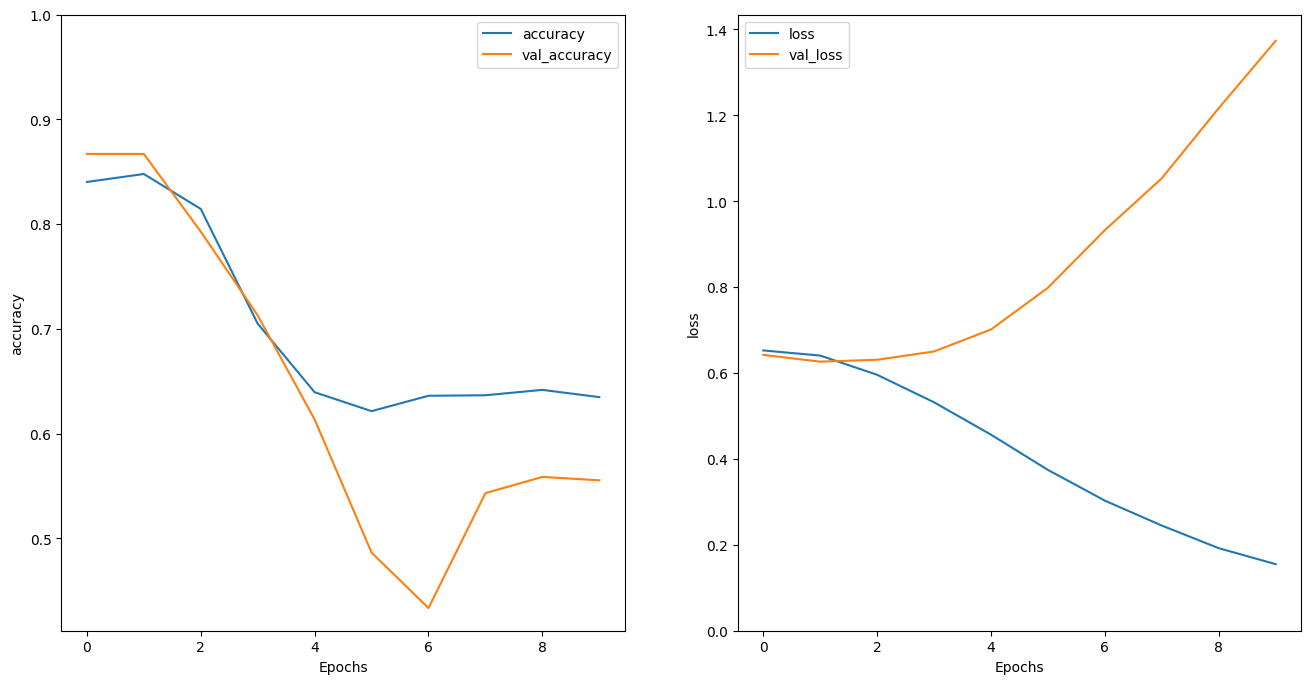

In [96]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [44]:
sample_text = ('This indie game was cool. The animation and the graphics '
               'were out of this world. I would recommend this game.')
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)
predictions = model.predict(encoded_example)
print(predictions)

sample_text = ('This game was cool. The animation and the graphics '
               'were out of this world. I would recommend this game.')
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)
predictions = model.predict(encoded_example)
print(predictions)

sample_text = ('This game was not cool. The animation and the graphics '
               'were basic, cheap. I would not recommend this game.')
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)
predictions = model.predict(encoded_example)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
[[0.4087369  0.18768243 0.40358067]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[0.412775   0.19301558 0.39420938]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[0.41358724 0.18730797 0.39910474]]


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True, use_cudnn=False)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, use_cudnn=False)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

NameError: name 'tf' is not defined

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(encoded_train_dataset, epochs=10,
                    validation_data=encoded_test_dataset,
                    validation_steps=30)

Epoch 1/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 46s 87ms/step - accuracy: 0.5764 - loss: 0.5984 - val_accuracy: 0.8188 - val_loss: 0.4095
Epoch 2/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - accuracy: 0.8313 - loss: 0.3805 - val_accuracy: 0.8630 - val_loss: 0.2952
Epoch 3/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 82s 178ms/step - accuracy: 0.8739 - loss: 0.3038 - val_accuracy: 0.9104 - val_loss: 0.2654
Epoch 4/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - accuracy: 0.8984 - loss: 0.2607 - val_accuracy: 0.9234 - val_loss: 0.2080
Epoch 5/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.9133 - loss: 0.2291 - val_accuracy: 0.9089 - val_loss: 0.2612
Epoch 6/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - accuracy: 0.9064 - loss: 0.2487 - val_accuracy: 0.9245 - val_loss: 0.1864
Epoch 7/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 40s 87ms/step - accuracy: 0.9272 - loss: 0.1961 - val_accuracy: 0.9427 - val_loss: 0.1662
Epoch 8/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 41s 87ms/step - accuracy: 0.9351 - loss: 0.1858 -

In [ ]:
test_loss, test_acc = model.evaluate(encoded_test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

460/460 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.9471 - loss: 0.1625
Test Loss: 0.16997113823890686
Test Accuracy: 0.9440195560455322


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)
predictions = model.predict(encoded_example)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
[[-2.170004]]


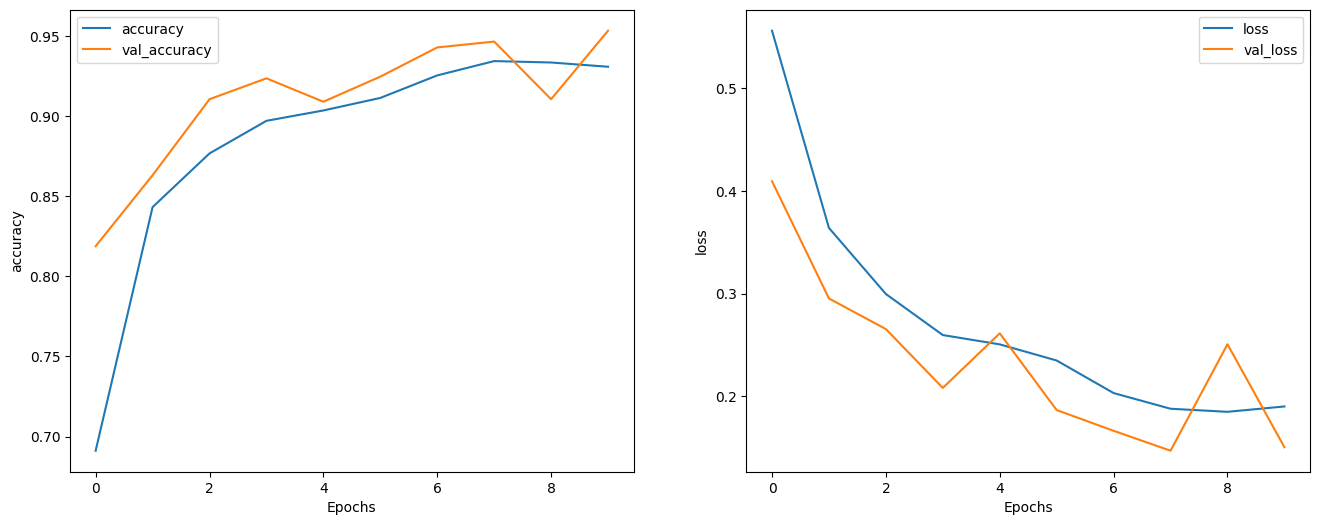

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
